In [1]:
import pandas as pd
import json
pd.set_option('display.max_columns', 500)

# df = pd.read_csv("/Users/yegortrussov/Documents/ml/lending_protocols/dataset_collection/data/markets_raw/eth_cbbtc_usdt.csv")
df = pd.read_csv("/Users/yegortrussov/Documents/ml/lending_protocols/dataset_collection/data/markets_raw/eth_cbbtc_usdc.csv")
# df = pd.read_csv("/Users/yegortrussov/Documents/ml/lending_protocols/dataset_collection/data/markets_raw/base_cbbtc_usdc_full.csv")
df = df[df["datetime"] < "2026-01-01"]
with open("/Users/yegortrussov/Documents/ml/lending_protocols/dataset_collection/data/common/markets_meta.json", 'r') as f:
    markets_meta = json.load(f)
with open("/Users/yegortrussov/Documents/ml/lending_protocols/dataset_collection/data/common/assets_meta.json", 'r') as f:
    assets_meta = json.load(f)
with open("/Users/yegortrussov/Documents/ml/lending_protocols/dataset_collection/data/common/vaults_meta.json", 'r') as f:
    vaults_meta = json.load(f)
market_addr = df["market_address"].unique()[0]
market_meta = markets_meta[market_addr]
asset_meta = assets_meta[market_meta["collateral_asset_address"]]
loan_asset_meta = assets_meta[market_meta["loan_asset_address"]]
loan_asset_meta["decimals"] = 6
all_vaults_addresses = vaults_meta.keys()
asset_price_df = pd.DataFrame(asset_meta["historical_price"], columns=["timestamp", "price"]).dropna()

# df = df[:200000]

market_meta

{'address': '0x64d65c9a2d91c36d56fbc42d69e979335320169b3df63bf92789e2c8883fcc64',
 'lltv': '860000000000000000',
 'oracle_address': '0xA6D6950c9F177F1De7f7757FB33539e3Ec60182a',
 'creation_datetime': 1725479483,
 'network': 'eth',
 'loan_asset_address': '0xA0b86991c6218b36c1d19D4a2e9Eb0cE3606eB48',
 'loan_asset_symbol': 'USDC',
 'loan_asset_decimals': 6,
 'collateral_asset_address': '0xcbB7C0000aB88B473b1f5aFd9ef808440eed33Bf',
 'collateral_asset_symbol': 'cbBTC',
 'collateral_asset_decimals': 8,
 'irm_curve': [[0, 0.010097412533685901, 0],
  [0.01, 0.010440836005609603, 0.00010440836005609603],
  [0.02, 0.010784259477533304, 0.0002156851895506661],
  [0.03, 0.011127682949457006, 0.00033383048848371015],
  [0.04, 0.011471106421380706, 0.00045884425685522825],
  [0.05, 0.011814529893304409, 0.0005907264946652204],
  [0.06, 0.01215795336522811, 0.0007294772019136866],
  [0.07, 0.012501376837151811, 0.0008750963786006269],
  [0.08, 0.012844800309075513, 0.001027584024726041],
  [0.09, 0.0

In [2]:
df.head(2)
# len(asset_meta["historical_price"])
# df["datetime"].max()


,hash,type,timestamp,user_address,assets,assets_usd,liquidated_assets,liquidated_assets_usd,market,datetime,market_address
0,0x55b1f9bfe77fa41b9f74b6949024ed40c61fda35554c...,MarketSupply,1726145495,0x29d4CDFee8F533af8529A9e1517b580E022874f7,1000000,0.999934,0,0.0,eth_cbbtc_usdc,2024-09-12 12:51:35,0x64d65c9a2d91c36d56fbc42d69e979335320169b3df6...
1,0x55b1f9bfe77fa41b9f74b6949024ed40c61fda35554c...,MarketSupplyCollateral,1726145495,0x29d4CDFee8F533af8529A9e1517b580E022874f7,5000,2.903950,0,0.0,eth_cbbtc_usdc,2024-09-12 12:51:35,0x64d65c9a2d91c36d56fbc42d69e979335320169b3df6...


In [3]:
import matplotlib.pyplot as plt
def plot_daily_metrics(df_orig, col="assets_usd", date_col="datetime", cutoff=None, agg_func='last'):
    df = df_orig.copy().fillna(0)
    df[date_col] = pd.to_datetime(df[date_col])
    
    df['date_only'] = df[date_col].dt.date
    
    if agg_func == 'last':
        df = df.sort_values(date_col)
        df = df.drop_duplicates(subset='date_only', keep='last')
    elif agg_func == 'mean':
        df = df.groupby('date_only')[col].mean().reset_index()
        df[date_col] = pd.to_datetime(df['date_only'])
    else:
        raise ValueError("agg_func must be 'last' or 'mean'")
    
    if cutoff is not None:
        df = df[df[date_col] >= cutoff]
    
    daily_df = df.groupby(date_col)[col].sum().reset_index()
    
    plt.figure(figsize=(14, 7))
    plt.plot(daily_df[date_col], daily_df[col], linewidth=2)
    
    plt.title(f'Daily {col} ({agg_func})', fontsize=16)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel(col, fontsize=12)
    plt.grid(True, alpha=0.3)
    
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


import plotly.graph_objects as go
import plotly.express as px
import pandas as pd

def plot_daily_metrics_express(df_orig, cols=["assets_usd"], date_col="datetime", 
                               cutoff=None, agg_func='last', price_df=None, price_col='price'):
    df = df_orig.copy().fillna(0)
    df[date_col] = pd.to_datetime(df[date_col])
    df['date_only'] = df[date_col].dt.date
    
    if agg_func == 'last':
        df = df.sort_values(date_col)
        df = df.drop_duplicates(subset='date_only', keep='last')
    elif agg_func == 'mean':
        grouped = df.groupby('date_only')[cols].mean().reset_index()
        df = grouped.copy()
        df[date_col] = pd.to_datetime(df['date_only'])
    
    if cutoff is not None:
        df = df[df[date_col] >= cutoff]
    
    daily_df = df.groupby(date_col)[cols].sum().reset_index()
    
    # Add price data if provided
    if price_df is not None:
        price_df = price_df.copy()
        price_df['datetime'] = pd.to_datetime(price_df['datetime'])
        price_df['date_only'] = price_df['datetime'].dt.date
        
        # Filter price_df to only dates in daily_df
        valid_dates = daily_df[date_col].dt.date.unique()
        price_df = price_df[price_df['date_only'].isin(valid_dates)]
        
        if not price_df.empty:
            # Get latest price per date
            daily_price = price_df.sort_values('datetime').drop_duplicates('date_only', keep='last')
            daily_price = daily_price[['date_only', price_col]]
            daily_price[date_col] = pd.to_datetime(daily_price['date_only'])
            
            # Merge with daily_df
            daily_df = pd.merge(daily_df, daily_price, on=date_col, how='left')
            cols = cols + [price_col]
    
    melted_df = daily_df.melt(id_vars=[date_col], value_vars=cols, 
                            var_name='metric', value_name='value')
    
    fig = px.line(
        melted_df, 
        x=date_col, 
        y='value',
        color='metric',
        title=f'Daily Metrics ({agg_func})',
        labels={'value': 'Value', date_col: 'Date', 'metric': 'Metric'},
        hover_data={date_col: '|%Y-%m-%d', 'value': ':,.5f'}
    )
    
    # Add secondary y-axis for price if present
    if price_df is not None and price_col in daily_df.columns:
        fig.update_layout(
            yaxis=dict(title="Primary Metrics"),
            yaxis2=dict(
                title="Price",
                overlaying="y",
                side="right",
                showgrid=False
            )
        )
        # Update price trace to use secondary axis
        price_trace_idx = len(cols) - 1  # Last trace is price
        fig.data[price_trace_idx].update(yaxis="y2")
    
    fig.update_traces(
        mode='lines+markers',
        line=dict(width=2),
        marker=dict(size=4),
        hovertemplate='<b>Date:</b> %{x|%Y-%m-%d}<br>' +
                     '<b>%{fullData.name}:</b> %{y:,.5f}<br>' +
                     '<extra></extra>'
    )
    
    fig.update_layout(
        width=1000,
        height=500,
        xaxis=dict(showgrid=True, gridwidth=1, gridcolor='LightGray'),
        yaxis=dict(showgrid=True, gridwidth=1, gridcolor='LightGray'),
        plot_bgcolor='white'
    )
    
    fig.show()

import plotly.express as px
import pandas as pd

def plot_metrics_timeseries(df_orig, col="assets_usd", date_col="datetime", cutoff=None):
    """
    Plot metrics as a timeseries with each row represented, sorted by timestamp.
    
    Parameters:
    - df_orig: DataFrame containing the data
    - col: Column name to plot
    - date_col: Name of the datetime column
    - cutoff: Minimum date to include (optional)
    """
    df = df_orig.copy().fillna(0)
    
    # Convert to datetime and sort by timestamp
    df[date_col] = pd.to_datetime(df[date_col])
    df = df.sort_values(date_col)
    
    # Apply cutoff if specified
    if cutoff is not None:
        cutoff = pd.to_datetime(cutoff)
        df = df[df[date_col] >= cutoff]
    
    # Create interactive plot with Plotly Express
    fig = px.line(
        df, 
        x=date_col, 
        y=col,
        title=f'Timeseries of {col}',
        labels={col: col, date_col: 'Timestamp'},
        hover_data={col: ':,.0f', date_col: '|%Y-%m-%d %H:%M:%S'}
    )
    
    # Customize the hover template to show full timestamp
    fig.update_traces(
        mode='lines+markers',
        line=dict(width=2),
        marker=dict(size=4),
        hovertemplate='<b>Timestamp:</b> %{x|%Y-%m-%d %H:%M:%S}<br>' +
                     f'<b>{col}:</b> %{{y:,.5f}}<br>' +
                     '<extra></extra>'
    )
    
    fig.update_layout(
        width=1200,
        height=600,
        xaxis=dict(
            showgrid=True, 
            gridwidth=1, 
            gridcolor='LightGray',
            title='Timestamp'
        ),
        yaxis=dict(
            showgrid=True, 
            gridwidth=1, 
            gridcolor='LightGray',
            title=col
        ),
        plot_bgcolor='white'
    )
    
    fig.show()
    
    return fig
    

In [10]:
from tqdm import tqdm
import numpy as np
def add_interest_rates(df, irm_data):
    u, b, s = np.array(irm_data).T
    
    df = df.copy()
    
    df['borrow_rate_before'] = np.interp(df["utilization_before"].clip(0, 1), u, b)
    df['supply_rate_before'] = np.interp(df["utilization_before"].clip(0, 1), u, s)
    
    df['borrow_rate_after'] = np.interp(df["utilization_after"].clip(0, 1), u, b)
    df['supply_rate_after'] = np.interp(df["utilization_after"].clip(0, 1), u, s)
    
    if 'new_utilization' in df.columns:
        df['borrow_rate_after'] = np.interp(df['new_utilization'].clip(0, 1), u, b)
        df['supply_rate_after'] = np.interp(df['new_utilization'].clip(0, 1), u, s)
    
    return df

def add_collateral_prices(df, price_data, col="collateral_price"):
    timestamps, prices = np.array(price_data).T
    
    df = df.copy()
    
    def find_closest_price(tx_timestamp):
        idx = np.searchsorted(timestamps, tx_timestamp)
        
        if idx == 0:
            return prices[0]
        elif idx == len(timestamps):
            return prices[-1]
        else:
            left_diff = tx_timestamp - timestamps[idx-1]
            right_diff = timestamps[idx] - tx_timestamp
            
            if left_diff <= right_diff:
                return prices[idx-1]
            else:
                return prices[idx]
    
    df[col] = df['timestamp'].apply(find_closest_price)
    
    if 'assets' in df.columns and col == "collateral_price":
        df['collateral_value'] = df['assets'] * df['collateral_price']
    
    return df

def add_rolling_mean_metric(df, metric, hours=6):
    df = df.sort_values('timestamp').copy()
    df_sorted = df.reset_index(drop=True)
    
    result = []
    for i in range(len(df_sorted)):
        current_time = df_sorted.at[i, 'timestamp']
        cutoff = current_time - (hours * 3600)
        mask = (df_sorted['timestamp'] >= cutoff) & (df_sorted['timestamp'] < current_time)
        rolling_mean = df_sorted.loc[mask, metric].mean()
        result.append(rolling_mean)
    
    df_sorted[f'{metric}_rolling'] = result
    return df_sorted

def calculate_metrics(df, irm_data, asset_data, loan_asset_data, use_collateral=False, use_usd_assets=False):
    df = df.fillna(0).sort_values(['timestamp', 'hash'])
    
    df = df.reset_index(drop=True)
    
    metrics_rows = []
    last_timestamp = df.iloc[0]['timestamp'] if len(df) > 0 else 0
    borrow_rate = 0.0
    supply_rate = 0.0

    total_supply = 0.0
    total_borrow = 0.0
    
    i = 0
    n = len(df)
    # pbar = tqdm(total=n)

    u, b, s = np.array(irm_data).T
    
    def get_rates(util):
        borrow_rate = np.interp(min(max(util, 0), 1), u, b)
        supply_rate = np.interp(min(max(util, 0), 1), u, s)
        return borrow_rate / 100, supply_rate / 100
    
    while i < n:
        current_hash = df.iloc[i]['hash']
        tx_start_idx = i
        
        tx_actions = []
        before_supply = total_supply
        before_borrow = total_borrow
        
        while i < n and df.iloc[i]['hash'] == current_hash:
            row = df.iloc[i]
            current_timestamp = row['timestamp']
            time_diff = (current_timestamp - last_timestamp) / (365 * 24 * 3600)
            
            current_util = total_borrow / total_supply if total_supply > 0 else 0
            borrow_rate, supply_rate = get_rates(current_util)
            
            total_borrow += total_borrow * (borrow_rate * 100 * time_diff)
            total_supply -= total_supply * (supply_rate * 100 * time_diff)
            
            last_timestamp = current_timestamp

            # pbar.update(1)
            amount = abs(0 if row['assets'] is None else float(row['assets']) / (10**loan_asset_data["decimals"]))
            if use_usd_assets:
                amount = float(row['assets']) / (10**loan_asset_data["decimals"]) if row['assets_usd'] is None else float(row["assets_usd"])

            if row['type'] in ['MarketSupply']:
                total_supply += amount
            elif row['type'] in ['MarketWithdraw']:
                total_supply -= amount
            if row['type'] == 'MarketBorrow':
                total_borrow += amount
            elif row['type'] == 'MarketRepay':
                total_borrow -= amount
            elif row['type'] == 'MarketLiquidation':
                total_borrow -= amount
                total_supply += amount
            
            i += 1
        
        after_supply = total_supply
        after_borrow = total_borrow
        
        before_util = before_borrow / before_supply if before_supply > 0 else 0
        after_util = after_borrow / after_supply if after_supply > 0 else 0
        
        metrics_rows.append({
            'hash': current_hash,
            'timestamp': df.iloc[tx_start_idx]['timestamp'],
            'datetime': df.iloc[tx_start_idx]['datetime'],
            'total_supply_before': before_supply,
            'total_borrow_before': before_borrow,
            'total_supply_after': after_supply,
            'total_borrow_after': after_borrow,
            'utilization_before': before_util,
            'utilization_after': after_util,
            'tx_actions': i - tx_start_idx
        })
    

    res = add_interest_rates(pd.DataFrame(metrics_rows), irm_data)
    print("Added interest rates")
    res = add_collateral_prices(res, asset_data["historical_price"])
    print("Added coll price")
    res = add_collateral_prices(res, loan_asset_data["historical_price"], col="loan_asset_price")
    print("Added loan asset price")
    # res = add_rolling_mean_metric(res, "borrow_rate_after")
    # print("Added Borrow rate after")
    # res = add_rolling_mean_metric(res, "supply_rate_after")
    # print("Added Borrow rate after")
    
    
    return res


# plot_daily_metrics_express(calculate_metrics(df, use_collateral=False), "utilization_after", agg_func="meann")
metrics = calculate_metrics(df, use_collateral=False, use_usd_assets=False, irm_data=market_meta["irm_curve"], asset_data=asset_meta, loan_asset_data=loan_asset_meta)
metrics
# _ = plot_metrics_timeseries(metrics, "utilization_after")
# _ = plot_daily_metrics_express(metrics, ["supply_rate_after", "borrow_rate_after"], agg_func="mean")
_ = plot_daily_metrics_express(metrics, ["total_supply_after", "total_borrow_after"], agg_func="last")
# _ = plot_daily_metrics_express(metrics, ["borrow_rate_after_rolling", "supply_rate_after_rolling"], agg_func="mean")

# _ = plot_metrics_timeseries(metrics, "borrow_rate_after")
# _ = plot_daily_metrics_express(metrics, ["collateral_price"], agg_func="last")


Added interest rates
Added coll price
Added loan asset price


In [14]:
df[df["datetime"].str[:10] == "2025-12-30"]
# df.head()
# _ = plot_daily_metrics_express(metrics, ["supply_rate_after", "borrow_rate_after"], agg_func="mean")
_ = plot_daily_metrics_express(metrics, ["utilization_after", "supply_rate_after", "borrow_rate_after"], agg_func="mean")


In [11]:
metrics.head(3)
loan_asset_meta
# asset_meta
# df.head(3)

{'asset_assress': '0xA0b86991c6218b36c1d19D4a2e9Eb0cE3606eB48',
 'decimals': 6,
 'symbol': 'USDC',
 'historical_price': [[1704204000, 1],
  [1704207600, 0.999168],
  [1704211200, 1],
  [1704214800, 1],
  [1704218400, 0.999965],
  [1704222000, 1.001],
  [1704225600, 1.001],
  [1704229200, 0.99998],
  [1704232800, 0.999986],
  [1704236400, 0.9995043975833083],
  [1704240000, 1],
  [1704243600, 1],
  [1704247200, 1],
  [1704250800, 1],
  [1704254400, 1.001],
  [1704258000, 0.999729],
  [1704261600, 0.999498],
  [1704265200, 1.001],
  [1704268800, 0.999982],
  [1704272400, 1.003],
  [1704276000, 0.999703],
  [1704279600, 1],
  [1704283200, 0.997063],
  [1704286800, 0.99977],
  [1704290400, 0.999059],
  [1704294000, 0.999661],
  [1704297600, 1.001],
  [1704301200, 1.001],
  [1704304800, 1.001],
  [1704308400, 0.991911],
  [1704312000, 0.999471],
  [1704315600, 1.001],
  [1704319200, 1],
  [1704322800, 0.999674],
  [1704326400, 1],
  [1704330000, 1.001],
  [1704333600, 0.999858],
  [17043372

In [12]:
# _ = plot_daily_metrics_express(metrics, ["total_borrow_after", "total_supply_after"], agg_func="mean")
# _ = plot_metrics_timeseries(asset_price_df, "price", date_col="timestamp")
asset_price_df["datetime"] = pd.to_datetime(asset_price_df['timestamp'], unit='s')
_ = plot_daily_metrics_express(metrics, ["total_supply_after", "total_borrow_after"], agg_func="mean", price_df=asset_price_df)


In [34]:
metrics1 = metrics.merge(df.drop_duplicates(["user_address", "hash"])[["user_address", "hash"]], how="left", on="hash")
metrics1.head(2)

,hash,timestamp,datetime,total_supply_before,total_borrow_before,total_supply_after,total_borrow_after,utilization_before,utilization_after,tx_actions,borrow_rate_before,supply_rate_before,borrow_rate_after,supply_rate_after,collateral_price,loan_asset_price,borrow_rate_after_rolling,supply_rate_after_rolling,date,user_address
0,0x55b1f9bfe77fa41b9f74b6949024ed40c61fda35554c...,1726145495,2024-09-12 12:51:35,0.0,0.00,1.000000,0.89,0.00,0.890,3,0.010097,0.000000,0.040662,0.036189,NaN,0.999641,NaN,NaN,2024-09-12,0x29d4CDFee8F533af8529A9e1517b580E022874f7
1,0x22baaa71fb1c274c83d015f6224090dc367e48c51507...,1726287455,2024-09-14 04:17:35,1.0,0.89,71824.187849,65000.89,0.89,0.905,3,0.040662,0.036189,0.047675,0.043179,60377.0,0.999770,NaN,NaN,2024-09-14,0x3F69bCdf3A61B3C84dC956a5cBdAC34CcB369D39


In [ ]:
asset_price_df[asset_price_df["datetime"] == asset_price_df["datetime"].min()], asset_price_df["timestamp"].min()
# asset_price_df["price"].isna().sum()

metrics1["date"] = metrics1["datetime"].str[:10]
# events_by_date = metrics1.groupby("date")["user_address"].nunique().reset_index().rename(columns={"user_address": "addr_cnt"})
events_by_date = metrics1.groupby("date")["user_address"].nunique().reset_index().rename(columns={"user_address": "addr_cnt"})
_ = plot_daily_metrics_express(events_by_date, ["addr_cnt"], agg_func="mean", price_df=asset_price_df, date_col="date")


In [ ]:
metrics.isna().sum()

hash                        0
timestamp                   0
datetime                    0
total_supply_before         0
total_borrow_before         0
total_supply_after          0
total_borrow_after          0
utilization_before          0
utilization_after           0
tx_actions                  0
borrow_rate_before          0
supply_rate_before          0
borrow_rate_after           0
supply_rate_after           0
collateral_price            0
loan_asset_price       915462
dtype: int64

In [96]:
from tqdm import tqdm

def classify_event(start_coll, start_debt, end_coll, end_debt, types_in_tx):
    # Epsilon for zero detection (use same as in your code)
    epsilon = 1e-6
    
    # Extract event types in this transaction
    tx_types = list(set(types_in_tx))
    
    # Liquidation events
    if 'MarketLiquidation' in tx_types:
        return 'liquidation'
    
    # Calculate changes
    delta_coll = end_coll - start_coll
    delta_debt = end_debt - start_debt
    
    # Check for opening position (from near-zero to positive)
    if start_coll < epsilon and start_debt < epsilon and end_coll > epsilon and end_debt > epsilon:
        return 'position_open'
    
    # Check for closing position (to near-zero)
    if end_coll < epsilon and end_debt < epsilon and (start_coll > epsilon or start_debt > epsilon):
        return 'position_close'
    
    # Full repay (debt goes to zero, collateral may or may not change)
    if end_debt < epsilon and abs(start_debt) > epsilon:
        return 'repay_full'
    
    # Partial repay (debt decreases but not to zero)
    if delta_debt < -epsilon and end_debt > epsilon:
        return 'repay_partial'
    
    # Add collateral only
    if delta_coll > epsilon and abs(delta_debt) < epsilon:
        return 'collateral_add'
    
    # Borrow more only
    if delta_debt > epsilon and abs(delta_coll) < epsilon:
        return 'borrow_more'
    
    # Withdraw collateral only
    if delta_coll < -epsilon and abs(delta_debt) < epsilon:
        return 'collateral_withdraw'
    
    if delta_coll > epsilon and delta_debt > epsilon:
        return 'borrow_more_w_collateral'
    
    # Both collateral and debt change significantly
    if abs(delta_coll) > epsilon and abs(delta_debt) > epsilon:
        return 'position_adjust'
    
    if start_coll < epsilon and start_debt < epsilon and end_coll < epsilon and end_debt < epsilon and 'MarketSupply' in tx_types:
        return 'loan_position_supply'
    if start_coll < epsilon and start_debt < epsilon and end_coll < epsilon and end_debt < epsilon and 'MarketWithdraw' in tx_types:
        return 'loan_position_withdraw'
    
    
    return 'other'


def add_user_ltv(df, market_data):
    df = df.sort_values(['user_address', 'timestamp', 'hash'])
    
    result_rows = []
    
    for address in tqdm(df['user_address'].unique()):
        user_df = df[df['user_address'] == address].copy()
        
        collateral = 0.0
        debt = 0.0
        
        current_hash = None
        hash_data = []
        
        for idx, row in user_df.iterrows():
            if row['hash'] != current_hash:
                if current_hash is not None and hash_data:
                    first_row = hash_data[0]
                    last_row = hash_data[-1]
                    types_in_tx = [row_dict['type'] for row_dict in hash_data]
                    event_type = classify_event(
                        start_collateral, start_debt, collateral, debt, types_in_tx
                    )
                    
                    price = first_row['collateral_price'] if 'collateral_price' in df.columns else 1.0
                    loan_asset_price = first_row['loan_asset_price']
                    if loan_asset_price is None:
                        loan_asset_price = 1
                    
                    before_ltv = start_debt / (start_collateral * price) if start_collateral * price > 0 else 0
                    after_ltv = debt / (collateral * price) if collateral * price > 0 else 0
                    
                    if (start_debt * loan_asset_price) == 0:
                        health_factor_before = 0
                    else:
                        health_factor_before = (start_collateral * price / loan_asset_price) * (float(market_data["lltv"]) / 10**18) / (start_debt * loan_asset_price)
                    
                    if (debt * loan_asset_price) == 0:
                        health_factor_after = 0
                    else:
                        health_factor_after = (collateral * price / loan_asset_price) * (float(market_data["lltv"]) / 10**18) / (debt * loan_asset_price)

                    for h_row in hash_data:
                        h_row['collateral_before'] = start_collateral
                        h_row['collateral_value_before'] = start_collateral * price
                        h_row['debt_before'] = start_debt  * loan_asset_price
                        h_row['ltv_before'] = before_ltv
                        h_row['collateral_after'] = collateral
                        h_row['collateral_value_after'] = collateral * price
                        h_row['debt_after'] = debt * loan_asset_price
                        h_row['ltv_after'] = after_ltv
                        h_row['health_factor_before'] = health_factor_before
                        h_row['health_factor_after'] = health_factor_after
                        h_row['event_type'] = event_type
                        
                        result_rows.append(h_row)
                
                current_hash = row['hash']
                hash_data = []
                start_collateral = collateral
                start_debt = debt
            
            row_dict = row.to_dict()
            
            amount = abs(float(row['assets']))
            
            if row['type'] in ['MarketSupplyCollateral']:
                collateral += amount / (10**asset_meta["decimals"])
            elif row['type'] in ['MarketWithdrawCollateral']:
                collateral -= amount / (10**asset_meta["decimals"])
            elif row['type'] == 'MarketBorrow':
                debt += amount / (10**loan_asset_meta["decimals"])
            elif row['type'] == 'MarketRepay':
                debt -= amount / (10**loan_asset_meta["decimals"])

            if abs(debt) < 1e-6:
                debt = 0 
            if abs(collateral) < 1e-11:
                collateral = 0 
            
            
            hash_data.append(row_dict)
        
        if current_hash is not None and hash_data:
            first_row = hash_data[0]
            last_row = hash_data[-1]

            types_in_tx = [row_dict['type'] for row_dict in hash_data]
            event_type = classify_event(
                start_collateral, start_debt, collateral, debt, types_in_tx
            )
            
            price = first_row['collateral_price']
            loan_asset_price = first_row['loan_asset_price']
            if loan_asset_price is None:
                loan_asset_price = 1
            
            before_ltv = (start_debt * loan_asset_price) / (start_collateral * price) if start_collateral * price > 0 else 0
            after_ltv = (debt * loan_asset_price) / (collateral * price) if collateral * price > 0 else 0
            
            if (start_debt) == 0:
                health_factor_before = 0
            else:
                health_factor_before = (start_collateral * price) * (float(market_data["lltv"]) / 10**18) / (start_debt)
            
            if (debt) == 0:
                health_factor_after = 0
            else:
                health_factor_after = (collateral * price) * (float(market_data["lltv"]) / 10**18) / (debt)

            for h_row in hash_data:
                h_row['collateral_before'] = start_collateral
                h_row['collateral_value_before'] = start_collateral * price
                h_row['debt_before'] = start_debt * loan_asset_price
                h_row['ltv_before'] = before_ltv
                h_row['collateral_after'] = collateral
                h_row['collateral_value_after'] = collateral * price
                h_row['debt_after'] = debt * loan_asset_price
                h_row['ltv_after'] = after_ltv
                h_row['health_factor_before'] = health_factor_before
                h_row['health_factor_after'] = health_factor_after
                h_row["event_type"] = event_type
                
                result_rows.append(h_row)
    
    result_df = pd.DataFrame(result_rows)
    result_df["health_factor_before"] = result_df["health_factor_before"].fillna(0)
    result_df["health_factor_after"] = result_df["health_factor_after"].fillna(0)
    result_df["health_factor_before"] = result_df["health_factor_before"].clip(0,1000)
    result_df["health_factor_after"] = result_df["health_factor_after"].clip(0,1000)
    
    result_df["vault_flg"] = result_df["user_address"].isin(all_vaults_addresses)

    return result_df.sort_values(["timestamp", "hash"])


df_w_user_ltv = add_user_ltv(df.merge(metrics.drop(columns=["timestamp", "datetime"]), how="left", on="hash"), market_meta)
df_w_user_ltv

100%|██████████| 628/628 [00:04<00:00, 147.07it/s]


,hash,type,timestamp,user_address,assets,assets_usd,liquidated_assets,liquidated_assets_usd,market,datetime,market_address,total_supply_before,total_borrow_before,total_supply_after,total_borrow_after,utilization_before,utilization_after,tx_actions,borrow_rate_before,supply_rate_before,borrow_rate_after,supply_rate_after,collateral_price,loan_asset_price,collateral_before,collateral_value_before,debt_before,ltv_before,collateral_after,collateral_value_after,debt_after,ltv_after,health_factor_before,health_factor_after,event_type,vault_flg
4938,0x55b1f9bfe77fa41b9f74b6949024ed40c61fda35554c...,MarketSupply,1726145495,0x29d4CDFee8F533af8529A9e1517b580E022874f7,1000000,0.999934,0,0.0,eth_cbbtc_usdc,2024-09-12 12:51:35,0x64d65c9a2d91c36d56fbc42d69e979335320169b3df6...,0.000000e+00,0.000000e+00,1.000000e+00,8.900000e-01,0.000000,0.89000,3,0.010097,0.000000,0.040662,0.036189,NaN,0.999641,0.000000,NaN,0.00000,0.000000,0.000050,NaN,0.889680,0.000000,0.000000,0.000000,position_open,False
4939,0x55b1f9bfe77fa41b9f74b6949024ed40c61fda35554c...,MarketSupplyCollateral,1726145495,0x29d4CDFee8F533af8529A9e1517b580E022874f7,5000,2.903950,0,0.0,eth_cbbtc_usdc,2024-09-12 12:51:35,0x64d65c9a2d91c36d56fbc42d69e979335320169b3df6...,0.000000e+00,0.000000e+00,1.000000e+00,8.900000e-01,0.000000,0.89000,3,0.010097,0.000000,0.040662,0.036189,NaN,0.999641,0.000000,NaN,0.00000,0.000000,0.000050,NaN,0.889680,0.000000,0.000000,0.000000,position_open,False
4940,0x55b1f9bfe77fa41b9f74b6949024ed40c61fda35554c...,MarketBorrow,1726145495,0x29d4CDFee8F533af8529A9e1517b580E022874f7,890000,0.889941,0,0.0,eth_cbbtc_usdc,2024-09-12 12:51:35,0x64d65c9a2d91c36d56fbc42d69e979335320169b3df6...,0.000000e+00,0.000000e+00,1.000000e+00,8.900000e-01,0.000000,0.89000,3,0.010097,0.000000,0.040662,0.036189,NaN,0.999641,0.000000,NaN,0.00000,0.000000,0.000050,NaN,0.889680,0.000000,0.000000,0.000000,position_open,False
5550,0x22baaa71fb1c274c83d015f6224090dc367e48c51507...,MarketSupplyCollateral,1726287455,0x3F69bCdf3A61B3C84dC956a5cBdAC34CcB369D39,299000000,180528.316330,0,0.0,eth_cbbtc_usdc,2024-09-14 04:17:35,0x64d65c9a2d91c36d56fbc42d69e979335320169b3df6...,1.000000e+00,8.900000e-01,7.182419e+04,6.500089e+04,0.890000,0.90500,3,0.040662,0.036189,0.047675,0.043179,60377.000000,0.999770,0.000000,0.00000,0.00000,0.000000,2.990000,180527.23000,64985.050000,0.360056,0.000000,2.389613,position_open,False
5551,0x22baaa71fb1c274c83d015f6224090dc367e48c51507...,MarketBorrow,1726287455,0x3F69bCdf3A61B3C84dC956a5cBdAC34CcB369D39,65000000000,64996.750000,0,0.0,eth_cbbtc_usdc,2024-09-14 04:17:35,0x64d65c9a2d91c36d56fbc42d69e979335320169b3df6...,1.000000e+00,8.900000e-01,7.182419e+04,6.500089e+04,0.890000,0.90500,3,0.040662,0.036189,0.047675,0.043179,60377.000000,0.999770,0.000000,0.00000,0.00000,0.000000,2.990000,180527.23000,64985.050000,0.360056,0.000000,2.389613,position_open,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33866,0xfffde09d6a19b24857be414ee5a65661c29bd65d297b...,MarketSupply,1767224723,0xBEEF01735c132Ada46AA9aA4c54623cAA92A64CB,15000000000,14997.945523,0,0.0,eth_cbbtc_usdc,2025-12-31 23:45:23,0x64d65c9a2d91c36d56fbc42d69e979335320169b3df6...,4.541409e+08,3.956286e+08,4.541559e+08,3.956286e+08,0.871158,0.87113,1,0.040015,0.034860,0.040014,0.034858,87435.493935,0.999830,0.000000,0.00000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,loan_position_supply,True
44063,0x13486e634cc073d911cfe547ea037e97ee38c9f32281...,MarketWithdraw,1767224795,0xBEefb9f61CC44895d8AEc381373555a64191A9c4,98014886,98.001461,0,0.0,eth_cbbtc_usdc,2025-12-31 23:46:35,0x64d65c9a2d91c36d56fbc42d69e979335320169b3df6...,4.541559e+08,3.956286e+08,4.541558e+08,3.956286e+08,0.871130,0.87113,1,0.040014,0.034858,0.040014,0.034858,87435.493935,0.999830,0.000000,0.00000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,loan_position_withdraw,True
44871,0x2597a120cda

In [94]:
df_w_user_ltv["event_type"].value_counts()
# df_w_user_ltv[df_w_user_ltv["event_type"] == "other"]["type"].value_counts()

event_type
loan_position_supply        25498
loan_position_withdraw      18995
repay_partial                2133
borrow_more_w_collateral     1867
borrow_more                  1769
collateral_add               1232
position_open                1185
position_close                557
collateral_withdraw           422
liquidation                    50
other                          30
repay_full                     19
position_adjust                 4
Name: count, dtype: int64

In [91]:
def add_price_features(df, price_df, lookback_hours=[1, 6, 24]):
    df = df.sort_values('timestamp').copy()
    price_df = price_df.sort_values('timestamp').copy()
    
    results = []
    price_values = price_df['price'].values
    price_times = price_df['timestamp'].values
    
    for _, row in df.iterrows():
        action_time = row['timestamp']
        features = {}

        zero = 0
        
        for hours in lookback_hours:
            lookback_seconds = hours * 3600
            start_time = action_time - lookback_seconds
            
            # Find indices in price data within window
            mask = (price_times >= start_time) & (price_times < action_time)
            window_prices = price_values[mask]
            
            if len(window_prices) >= 2:
                # Calculate returns
                returns = np.diff(window_prices) / window_prices[:-1]
                
                features[f'volatility_{hours}h'] = returns.std() if len(returns) > 0 else 0
                features[f'drawdown_{hours}h'] = (window_prices.min() - window_prices[-1]) / window_prices[-1]
                features[f'trend_{hours}h'] = (window_prices[-1] - window_prices[0]) / window_prices[0] if window_prices[0] != 0 else 0
            else:
                features[f'volatility_{hours}h'] = 0
                features[f'drawdown_{hours}h'] = 0
                features[f'trend_{hours}h'] = 0
        
        results.append(features)
    
    price_features_df = pd.DataFrame(results, index=df.index)
    return pd.concat([df, price_features_df], axis=1)


df_w_price = add_price_features(df_w_user_ltv, asset_price_df)
df_w_price.head(3)

,hash,type,timestamp,user_address,assets,assets_usd,liquidated_assets,liquidated_assets_usd,market,datetime,market_address,total_supply_before,total_borrow_before,total_supply_after,total_borrow_after,utilization_before,utilization_after,tx_actions,borrow_rate_before,supply_rate_before,borrow_rate_after,supply_rate_after,collateral_price,loan_asset_price,collateral_before,collateral_value_before,debt_before,ltv_before,collateral_after,collateral_value_after,debt_after,ltv_after,health_factor_before,health_factor_after,event_type,vault_flg,volatility_1h,drawdown_1h,trend_1h,volatility_6h,drawdown_6h,trend_6h,volatility_24h,drawdown_24h,trend_24h
4938,0x55b1f9bfe77fa41b9f74b6949024ed40c61fda35554c...,MarketSupply,1726145495,0x29d4CDFee8F533af8529A9e1517b580E022874f7,1000000,0.999934,0,0.0,eth_cbbtc_usdc,2024-09-12 12:51:35,0x64d65c9a2d91c36d56fbc42d69e979335320169b3df6...,0.0,0.0,1.0,0.89,0.0,0.89,3,0.010097,0.0,0.040662,0.036189,NaN,0.999641,0.0,NaN,0.0,0.0,0.00005,NaN,0.88968,0.0,0.0,0.0,position_open,False,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
4939,0x55b1f9bfe77fa41b9f74b6949024ed40c61fda35554c...,MarketSupplyCollateral,1726145495,0x29d4CDFee8F533af8529A9e1517b580E022874f7,5000,2.903950,0,0.0,eth_cbbtc_usdc,2024-09-12 12:51:35,0x64d65c9a2d91c36d56fbc42d69e979335320169b3df6...,0.0,0.0,1.0,0.89,0.0,0.89,3,0.010097,0.0,0.040662,0.036189,NaN,0.999641,0.0,NaN,0.0,0.0,0.00005,NaN,0.88968,0.0,0.0,0.0,position_open,False,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
4940,0x55b1f9bfe77fa41b9f74b6949024ed40c61fda35554c...,MarketBorrow,1726145495,0x29d4CDFee8F533af8529A9e1517b580E022874f7,890000,0.889941,0,0.0,eth_cbbtc_usdc,2024-09-12 12:51:35,0x64d65c9a2d91c36d56fbc42d69e979335320169b3df6...,0.0,0.0,1.0,0.89,0.0,0.89,3,0.010097,0.0,0.040662,0.036189,NaN,0.999641,0.0,NaN,0.0,0.0,0.00005,NaN,0.88968,0.0,0.0,0.0,position_open,False,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


<Axes: >

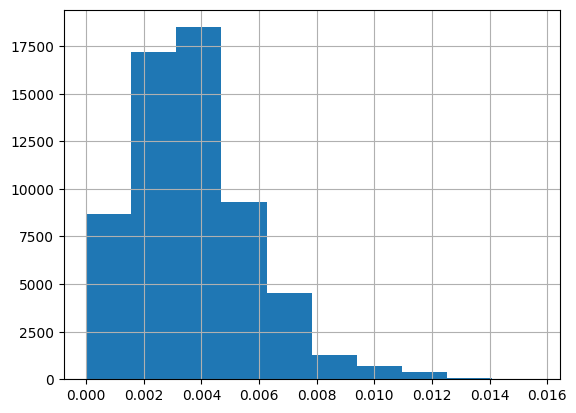

In [58]:
# df_w_price[df_w_price["volatility_6h"] > 0]["volatility_6h"].hist()
# df_w_price[df_w_price["volatility_24h"] > 0]["volatility_24h"].hist()

# df_w_price["trend_6h"].hist()
df_w_price["volatility_24h"].hist()

# df_w_price["volatility_6h"].value_counts()

In [44]:
df_w_price["trend_1h"].nunique()
# asset_price_df

1

In [32]:
import os
os.listdir("/Users/yegortrussov/Documents/ml/lending_protocols/dataset_collection/data/markets_raw")

['base_wbtc_usdc.csv',
 'base_wbtc_usdt.csv',
 'eth_cbbtc_usdt.csv',
 'eth_cbbtc_usdc.csv',
 'base_weth_usdt.csv',
 'base_wsteth_usdt.csv',
 'base_wsteth_usdc.csv',
 'base_cbbtc_usdt.csv',
 'base_cbbtc_usdc.csv',
 'eth_wbtc_usdc.csv',
 'eth_wbtc_usdt.csv',
 'base_cbbtc_usdc_1.csv',
 'eth_weth_usdt.csv',
 'eth_wsteth_usdt.csv',
 'eth_wsteth_usdc.csv']

In [100]:
import os 
def build_enriched_df(name, raw_df, market_meta, asset_data, loan_asset_data):
    metrics = calculate_metrics(
        raw_df[raw_df["datetime"].astype(str) < "2026-01-01"],
        use_collateral=False,
        irm_data=market_meta["irm_curve"],
        asset_data=asset_data,
        loan_asset_data=loan_asset_data
    )

    enriched = raw_df.merge(metrics.drop(columns=["timestamp", "datetime"]))
    asset_price_df = pd.DataFrame(asset_meta["historical_price"], columns=["timestamp", "price"]).dropna()
    enriched = add_user_ltv(enriched, market_data=market_meta)
    enriched = add_price_features(enriched, asset_price_df)

    enriched.to_csv(f"/Users/yegortrussov/Documents/ml/lending_protocols/dataset_collection/data/markets_enriched/{name}.csv", index=False)


raw_path = "/Users/yegortrussov/Documents/ml/lending_protocols/dataset_collection/data/markets_raw"
# for file in tqdm(os.listdir(raw_path)):
for file in tqdm(["base_cbbtc_usdc_full.csv"]):
    print("processing file", file)
    # if "base" in file:
    #     continue
    raw_df = pd.read_csv(raw_path + "/" + file)
    print(raw_df.shape)
    # raw_df = raw_df[:200_000]
    address = raw_df["market_address"].unique()[0]
    market_meta = markets_meta[address]
    print(address)
    asset_meta = assets_meta[market_meta["collateral_asset_address"]]
    loan_asset_meta = assets_meta[market_meta["loan_asset_address"]]
    loan_asset_meta["decimals"] = 6
    build_enriched_df(
        file.split(".")[0],
        raw_df,
        market_meta,
        asset_meta,
        loan_asset_meta,
    )



# build_enriched_df(
#     "eth_cbbtc_usdt",
#     df,
#     market_meta
# )

  0%|          | 0/1 [00:00<?, ?it/s]

processing file base_cbbtc_usdc_full.csv
(1110000, 9)
0x9103c3b4e834476c9a62ea009ba2c884ee42e94e6e314a26f04d312434191836
Added interest rates
Added coll price
Added loan asset price


100%|██████████| 1/1 [50:30<00:00, 3030.86s/it]


In [ ]:
df["type"].unique()
df

,hash,type,timestamp,user_address,assets,assets_usd,market,datetime,market_address
0,0xa5d64f0a0881150ac9e209470f4378f897d812965951...,MarketSupply,1761446903,0xB47f11484e19f1914D32fd393b17671221C10F1F,1000000,1.000362,eth_cbbtc_usdt,2025-10-26 02:48:23,0x45671fb8d5dea1c4fbca0b8548ad742f6643300eeb8d...
1,0x769086d9812ed5f61210015e00744e7597370e9d4812...,MarketSupplyCollateral,1761446927,0xB47f11484e19f1914D32fd393b17671221C10F1F,3000,3.354816,eth_cbbtc_usdt,2025-10-26 02:48:47,0x45671fb8d5dea1c4fbca0b8548ad742f6643300eeb8d...
2,0x0bd7a21adc448f0be70f9aeff1810e4aadf81594cea1...,MarketBorrow,1761446939,0xB47f11484e19f1914D32fd393b17671221C10F1F,1000000,1.000362,eth_cbbtc_usdt,2025-10-26 02:48:59,0x45671fb8d5dea1c4fbca0b8548ad742f6643300eeb8d...
3,0x5773092976efbd11bac571c4a18dec90c787d40014ad...,MarketSupply,1761763931,0xB47f11484e19f1914D32fd393b17671221C10F1F,200000,0.200042,eth_cbbtc_usdt,2025-10-29 18:52:11,0x45671fb8d5dea1c4fbca0b8548ad742f6643300eeb8d...
4,0x8eac7ccf48aecf50b6ac24ea1fb2bc8993f5d4f92618...,MarketSupply,1761769415,0x79FD640000F8563A866322483524a4b48f1Ed702,10011631050,10015.332011,eth_cbbtc_usdt,2025-10-29 20:23:35,0x45671fb8d5dea1c4fbca0b8548ad742f6643300eeb8d...
...,...,...,...,...,...,...,...,...,...
1278,0xec944a4c9ffd4d229fd547cf65025ebf19c116c7de7b...,MarketSupply,1767695531,0x8CB3649114051cA5119141a34C200D65dc0Faa73,79832402742,79803.968192,eth_cbbtc_usdt,2026-01-06 10:32:11,0x45671fb8d5dea1c4fbca0b8548ad742f6643300eeb8d...
1279,0xbfde4a6f74683ed2ecd0a8075eafa4a85222ea014370...,MarketWithdrawCollateral,1767708419,0x7EA3A42531919F3AfEE4Dd80166c0289F5cdA169,20000000,18742.120300,eth_cbbtc_usdt,2026-01-06 14:06:59,0x45671fb8d5dea1c4fbca0b8548ad742f6643300eeb8d...
1280,0x06f5d7b58441fe2f20e6c55e36bcfe4d785bc3cc66e3...,MarketRepay,1767709355,0x7EA3A42531919F3AfEE4Dd80166c0289F5cdA169,8774062107,8771.022130,eth_cbbtc_usdt,2026-01-06 14:22:35,0x45671fb8d5dea1c4fbca0b8548ad742f6643300eeb8d...
1281,0x06f5d7b58441fe2f20e6c55e36bcfe4d785bc3cc66e3...,MarketWithdrawCollateral,1767709355,0x7EA3A42531919F3AfEE4Dd80166c0289F5cdA169,15000000,14056.590225,eth_cbbtc_usdt,2026-01-06 14:22:35,0x45671fb8d5dea1c4fbca0b8548ad742f6643300eeb8d...


In [ ]:
dd = pd.read_csv("/Users/yegortrussov/Documents/ml/lending_protocols/dataset_collection/data/markets_raw/eth_weth_usdt.csv")
float("1000")

0        7
1       16
2        7
3       17
4        8
        ..
2195    15
2196     6
2197     6
2198    14
2199    10
Name: assets, Length: 2200, dtype: int64

In [24]:
df1 = pd.read_csv("/Users/yegortrussov/Documents/ml/lending_protocols/dataset_collection/data/markets_enriched/base_cbbtc_usdc.csv")

_ = plot_daily_metrics_express(df1, ["supply_rate_after", "borrow_rate_after"], agg_func="last")
# _ = plot_daily_metrics_express(df1, ["total_supply_after", "total_borrow_after"], agg_func="last")


FileNotFoundError: [Errno 2] No such file or directory: '/Users/yegortrussov/Documents/ml/lending_protocols/dataset_collection/data/markets_enriched/base_cbbtc_usdc.csv'

In [49]:
df1.head(2)

,hash,type,timestamp,user_address,assets,assets_usd,market,datetime,market_address,total_supply_before,total_borrow_before,total_supply_after,total_borrow_after,utilization_before,utilization_after,tx_actions,borrow_rate_before,supply_rate_before,borrow_rate_after,supply_rate_after,collateral_price,loan_asset_price,collateral_before,collateral_value_before,debt_before,ltv_before,collateral_after,collateral_value_after,debt_after,ltv_after
0,0x55b1f9bfe77fa41b9f74b6949024ed40c61fda35554c...,MarketSupply,1726145495,0x29d4CDFee8F533af8529A9e1517b580E022874f7,1000000,0.999934,eth_cbbtc_usdc,2024-09-12 12:51:35,0x64d65c9a2d91c36d56fbc42d69e979335320169b3df6...,0.0,0.0,166666.666667,148333.333333,0.0,0.89,3,0.010097,0.0,0.040662,0.036189,NaN,0.999641,0.0,NaN,0.0,0.0,0.00005,NaN,0.88968,0.0
1,0x55b1f9bfe77fa41b9f74b6949024ed40c61fda35554c...,MarketSupplyCollateral,1726145495,0x29d4CDFee8F533af8529A9e1517b580E022874f7,5000,2.903950,eth_cbbtc_usdc,2024-09-12 12:51:35,0x64d65c9a2d91c36d56fbc42d69e979335320169b3df6...,0.0,0.0,166666.666667,148333.333333,0.0,0.89,3,0.010097,0.0,0.040662,0.036189,NaN,0.999641,0.0,NaN,0.0,0.0,0.00005,NaN,0.88968,0.0
